# Text Analytics

#### Charlie Marshall
#### Prof. Klabjan
#### IEMS 308
#### 2 March 2020

In [2]:
import pandas as pd
import numpy as np
import scipy
import re
import glob
import os
from nltk.tokenize import word_tokenize,sent_tokenize,RegexpTokenizer
from nltk import pos_tag
import spacy

from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,confusion_matrix

from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))

from imblearn.over_sampling import SMOTE
import statsmodels.api as sm

### Load in Data

In [3]:
percent = pd.read_csv("/Users/charlesmarshall/Desktop/IEMS 308/Project 3/all/percentage.csv", engine = "python", names = ['perc'])

In [4]:
percent.head()

,perc
0,66%
1,40%
2,90%
3,49%
4,100%


In [5]:
ceo = pd.read_csv("/Users/charlesmarshall/Desktop/IEMS 308/Project 3/all/ceo.csv", engine = "python", names = ['first', 'last'])

In [6]:
def ceo_name(df):
    for i in range(len(ceo)):
        if pd.isnull(ceo.loc[i,'last']):
            ceo.loc[i,'ceo_full'] = ceo.loc[i,'first']
        elif pd.isnull(ceo.loc[i,'first']):
            ceo.loc[i,'ceo_full'] = ceo.loc[i,'last']
        else:
            ceo.loc[i,'ceo_full'] = ceo.loc[i,'first'] + ' ' + ceo.loc[i,'last']
            
    return df;

In [7]:
ceo = ceo_name(ceo)

In [8]:
ceo = ceo.drop(['first','last'], axis=1)

In [9]:
ceo.head()

,ceo_full
0,Tom Horton
1,Patti Hart
2,Jamie Dimon
3,Steve Cohen
4,Tim Cook


In [10]:
company = pd.read_csv("/Users/charlesmarshall/Desktop/IEMS 308/Project 3/all/companies.csv", engine = "python", names = ['company'])

In [11]:
company.head()

,company
0,Abaxis Inc
1,ACA Financial
2,Alibaba Group Holding Ltd
3,American Bell Telephone Co
4,American Express Co


In [12]:
file_list = glob.glob("/Users/charlesmarshall/Desktop/IEMS 308/Project 3/*/*.txt")

corpus = []

for file_path in file_list:
    with open(file_path,encoding='ISO-8859-1') as f_input:
        corpus.append(f_input.read())

In [13]:
len(corpus)

730

## Clean data

Remove all unicode and *.

In [14]:
print(corpus[0])

ReutersChina's seven day repo rose to a record high of 10.77% in Shanghai, the highest since March 2003, according to Bloomberg*. Meanwhile, the one-day rate hit a record 12.85%. And Zerohedge reported that overnight repo hit 25%. The liquidity squeeze in China first began ahead of the Dragon Boat festival earlier this month. Spikes in interbank rates are common right before holidays.Â  But Diana Choyleva at Lombard Street Research said this is symptomatic of a bigger problem. She said capital flows had "become a more important driver of domestic liquidity conditions in China's managed exchange rate system." In a new note to clients Bank of America's Ting Lu wrote: "There are many factors behind the interbank liquidity squeeze that might be cited, but we believe that the ultimate reason is the central bankâs tough stance as the PBOC can practically provide unlimited liquidity to ease every squeeze if it wishes to."Â  Banks have been clamoring for a reserve requirement ratio cut. So w

In [15]:
for text in range(len(corpus)):
    corpus[text] = re.sub(r'[^\x00-\x7f]|[*]',r'', corpus[text])

In [16]:
print(corpus[0])

ReutersChina's seven day repo rose to a record high of 10.77% in Shanghai, the highest since March 2003, according to Bloomberg. Meanwhile, the one-day rate hit a record 12.85%. And Zerohedge reported that overnight repo hit 25%. The liquidity squeeze in China first began ahead of the Dragon Boat festival earlier this month. Spikes in interbank rates are common right before holidays. But Diana Choyleva at Lombard Street Research said this is symptomatic of a bigger problem. She said capital flows had "become a more important driver of domestic liquidity conditions in China's managed exchange rate system." In a new note to clients Bank of America's Ting Lu wrote: "There are many factors behind the interbank liquidity squeeze that might be cited, but we believe that the ultimate reason is the central banks tough stance as the PBOC can practically provide unlimited liquidity to ease every squeeze if it wishes to." Banks have been clamoring for a reserve requirement ratio cut. So why isn't

## Tokenizing the Sentences

In [17]:
sentences = []

for text in range(len(corpus)):
    s = sent_tokenize(corpus[text])
    sentences.append(s)

In [18]:
len(sentences)

730

In [19]:
sentences = [item for sublist in sentences for item in sublist]

In [20]:
len(sentences)

695841

In [21]:
sentences[6940]

'Crablike, Mr Hollande is trying to do just enough on Europe, without aggravating nationalism at home.'

### Removing stop words in sentences:

None of the categories we are looking for (CEOs, percentages, or Companies) should include stop words,
so  removing them will not eliminate any candidates which simulataneously eliminating candidates which do not deserve to be picked

In [22]:
stop_words=sorted(set(stopwords.words("english")))

In [23]:
def drop_stop_words(ls):
    for i in range(len(ls)):
        tokenized_sent = word_tokenize(ls[i])
        ls[i] = ' '.join([word for word in tokenized_sent if word.lower() not in stop_words])
        
    return ls;

In [24]:
sentences = drop_stop_words(sentences)

In [25]:
sentences[6940]

'Crablike , Mr Hollande trying enough Europe , without aggravating nationalism home .'

## CEO's

1) Find all the names of people included in the corpus (potential CEO's). This is done by searching for any value that has two uppercase words in a row or just one uppercase word. It is not the most exact way to do this (for instance, there are lots of words at the beginning of sentences which are included, but many of these words should be eliminated in feature selection.

2) Blocks of text (paragraphs, windows, sentences, etc) will be inspected to come up with features.

- Potential Features:
1) CEO is in the same sentence (should correctly identify people who are obviously CEOs)
2) Word/ word phrase is longer than 3 characters (many of the stop words which are included in the potential ceo list are just words which start sentences, but can be eliminated because they have only a few characters)
3) I'm not sure - this might be good

3) A df will then be created with the row name being the name of each person and each column being a feature. 

4) Train a logistic regression model on half of the data

5) Test the model on the other half of the data. 

### Creating df for classification

In [26]:
def cap_letters(message):
    caps = sum(1 for c in message if c.isupper())
    return caps;

In [27]:
def cap_in_sent(ls):
    sent_caps = sum(1 for c in ls if c.isupper())
    return sent_caps;

In [28]:
def sentence_words(ls):
    ceos = 0
    sens = 0
    pres = 0
    inv = 0
    aut = 0
    represent = 0
    ambass = 0
    secr = 0
    exp = 0
    spok = 0
    gov = 0
    part = 0
    found = 0
    who=0
    
    if re.findall(r'CEO|ceo', ls) != []: 
        ceos = 1
    if re.findall(r'Senator|Sen.', ls) != []: 
        sens = 1
    if re.findall(r'President', ls) != []: 
        pres = 1
    if re.findall(r'investor|Investor', ls) != []: 
        inv = 1
    if re.findall(r'author|Author', ls) != []: 
        aut = 1
    if re.findall(r'Representative|Rep.', ls) != []: 
        represent = 1
    if re.findall(r'Ambassador|ambassador', ls) != []: 
        ambass = 1
    if re.findall(r'Secretary|secretary', ls) != []: 
        secr = 1
    if re.findall(r'Expert|expert', ls) != []: 
        exp = 1
    if re.findall(r'spokesman|spokeswoman|Spokesman|Spokeswoman', ls) != []: 
        spok = 1
    if re.findall(r'Governor|Gov.', ls) != []: 
        gov = 1
    if re.findall(r'partner|Partner', ls) != []: 
        part = 1
    if re.findall(r'founder|Founder', ls) != []:
        found = 1
    if re.findall(r'who|Who', ls) != []:
        who = 1
        
    return ceos, sens, pres, inv, aut, represent, ambass, secr, exp, spok, gov, part, found,who;

In [29]:
def person_two_before(sent,phrase_in_sent):
    try:
        who_two_before = 0
        ceo_two_before = 0
        sen_two_before = 0
        pres_two_before = 0
        inv_two_before = 0
        aut_two_before = 0
        rep_two_before = 0
        amb_two_before = 0
        sec_two_before = 0
        exp_two_before = 0
        spoke_two_before = 0
        gov_two_before = 0
        part_two_before = 0
        found_two_before = 0
        
        sec_word = ''

        sent_split = re.split(r'[ |,|.]', sent)
        last_word = re.split(r'[ ]', phrase_in_sent)[0]

        if last_word in sent_split:
            word_index = sent_split.index(last_word)
            sec_word = sent_split[word_index-2].lower()
            if word_index-2 >= 0:
                if sec_word == 'who':
                    who_two_before = 1;
                if sec_word == 'ceo':
                    ceo_two_before = 1;
                if sec_word == 'senator' or sec_word == 'sen':
                    sen_two_before = 1;
                if sec_word == 'president':
                    pres_two_before = 1;
                if sec_word == 'investor':
                    inv_two_before = 1;
                if sec_word == 'author':
                    aut_two_before = 1;
                if sec_word == 'representative' or sec_word == 'rep':
                    rep_two_before = 1;
                if sec_word == 'ambassador':
                    amb_two_before = 1;
                if sec_word == 'secretary':
                    sec_two_before = 1;
                if sec_word == 'expert':
                    exp_two_before = 1;
                if sec_word == 'spokesman' or sec_word == 'spokeswoman':
                    spoke_two_before = 1;
                if sec_word == 'governor':
                    gov_two_before = 1;
                if sec_word == 'partner':
                    part_two_before = 1;
                if sec_word == 'founder':
                    found_two_before = 1;
                return who_two_before,ceo_two_before,sen_two_before,pres_two_before,inv_two_before,aut_two_before,rep_two_before,amb_two_before,sec_two_before,exp_two_before,spoke_two_before,gov_two_before,part_two_before,found_two_before;
            else:
                return who_two_before,ceo_two_before,sen_two_before,pres_two_before,inv_two_before,aut_two_before,rep_two_before,amb_two_before,sec_two_before,exp_two_before,spoke_two_before,gov_two_before,part_two_before,found_two_before;
    except IndexError:  
        return who_two_before,ceo_two_before,sen_two_before,pres_two_before,inv_two_before,aut_two_before,rep_two_before,amb_two_before,sec_two_before,exp_two_before,spoke_two_before,gov_two_before,part_two_before,found_two_before;

In [30]:
def person_one_before(sent,phrase_in_sent):
    try:
        who_one_before = 0
        ceo_one_before = 0
        sen_one_before = 0
        pres_one_before = 0
        inv_one_before = 0
        aut_one_before = 0
        rep_one_before = 0
        amb_one_before = 0
        sec_one_before = 0
        exp_one_before = 0
        spoke_one_before = 0
        gov_one_before = 0
        part_one_before = 0
        found_one_before = 0
        
        sec_word = ''

        sent_split = re.split(r'[ |,|.]', sent)
        last_word = re.split(r'[ ]', phrase_in_sent)[0]

        if last_word in sent_split:
            word_index = sent_split.index(last_word)
            sec_word = sent_split[word_index - 1].lower()
            if word_index - 1 >= 0:
                if sec_word == 'who':
                    who_one_before = 1;
                if sec_word == 'ceo':
                    ceo_one_before = 1;
                if sec_word == 'senator' or sec_word == 'sen':
                    sen_one_before = 1;
                if sec_word == 'president':
                    pres_one_before = 1;
                if sec_word == 'investor':
                    inv_one_before = 1;
                if sec_word == 'author':
                    aut_one_before = 1;
                if sec_word == 'representative' or sec_word == 'rep':
                    rep_one_before = 1;
                if sec_word == 'ambassador':
                    amb_one_before = 1;
                if sec_word == 'secretary':
                    sec_one_before = 1;
                if sec_word == 'expert':
                    exp_one_before = 1;
                if sec_word == 'spokesman' or sec_word == 'spokeswoman':
                    spoke_one_before = 1;
                if sec_word == 'governor':
                    gov_one_before = 1;
                if sec_word == 'partner':
                    part_one_before = 1;
                if sec_word == 'founder':
                    found_one_before = 1;
                return who_one_before,ceo_one_before,sen_one_before,pres_one_before,inv_one_before,aut_one_before,rep_one_before,amb_one_before,sec_one_before,exp_one_before,spoke_one_before,gov_one_before,part_one_before,found_one_before;
            else:
                return who_one_before,ceo_one_before,sen_one_before,pres_one_before,inv_one_before,aut_one_before,rep_one_before,amb_one_before,sec_one_before,exp_one_before,spoke_one_before,gov_one_before,part_one_before,found_one_before;
    except IndexError:  
        return who_one_before,ceo_one_before,sen_one_before,pres_one_before,inv_one_before,aut_one_before,rep_one_before,amb_one_before,sec_one_before,exp_one_before,spoke_one_before,gov_one_before,part_one_before,found_one_before;

In [31]:
def person_one_after(sent,phrase_in_sent):
    try:
        who_one_after = 0
        ceo_one_after = 0
        sen_one_after = 0
        pres_one_after = 0
        inv_one_after = 0
        aut_one_after = 0
        rep_one_after = 0
        amb_one_after = 0
        sec_one_after = 0
        exp_one_after = 0
        spoke_one_after = 0
        gov_one_after = 0
        part_one_after = 0
        found_one_after = 0
        
        fst_word = ''

        sent_split = re.split(r'[ |,|.]', sent)
        last_word = re.split(r'[ ]', phrase_in_sent)[1]

        if last_word in sent_split:
            word_index = sent_split.index(last_word)
            fst_word = sent_split[word_index+1].lower()

            if fst_word == 'who':
                who_one_after = 1;
            if fst_word == 'ceo':
                ceo_one_after = 1;
            if fst_word == 'senator' or fst_word == 'sen':
                sen_one_after = 1;
            if fst_word == 'president':
                pres_one_after = 1;
            if fst_word == 'investor':
                inv_one_after = 1;
            if fst_word == 'author':
                aut_one_after = 1;
            if fst_word == 'representative'or fst_word == 'rep':
                rep_one_after = 1;
            if fst_word == 'ambassador':
                amb_one_after = 1;
            if fst_word == 'secretary':
                sec_one_after = 1;
            if fst_word == 'expert':
                exp_one_after = 1;
            if fst_word == 'spokesman' or fst_word == 'spokeswoman':
                spoke_one_after = 1;
            if fst_word == 'governor':
                gov_one_after = 1;
            if fst_word == 'partner':
                part_one_after = 1;
            if fst_word == 'founder':
                found_one_after = 1;
        return who_one_after,ceo_one_after,sen_one_after,pres_one_after,inv_one_after,aut_one_after,rep_one_after,amb_one_after,sec_one_after,exp_one_after,spoke_one_after,gov_one_after,part_one_after,found_one_after;
    except IndexError:  
        return who_one_after,ceo_one_after,sen_one_after,pres_one_after,inv_one_after,aut_one_after,rep_one_after,amb_one_after,sec_one_after,exp_one_after,spoke_one_after,gov_one_after,part_one_after,found_one_after;

In [32]:
def person_two_after(sent,phrase_in_sent):
    try:
        who_two_after = 0
        ceo_two_after = 0
        sen_two_after = 0
        pres_two_after = 0
        inv_two_after = 0
        aut_two_after = 0
        rep_two_after = 0
        amb_two_after = 0
        sec_two_after = 0
        exp_two_after = 0
        spoke_two_after = 0
        gov_two_after = 0
        part_two_after = 0
        found_two_after = 0
        
        sec_word = ''

        sent_split = re.split(r'[ |,|.]', sent)
        last_word = re.split(r'[ ]', phrase_in_sent)[1]

        if last_word in sent_split:
            word_index = sent_split.index(last_word)
            sec_word = sent_split[word_index+2].lower()

            if sec_word == 'who':
                who_two_after = 1;
            if sec_word == 'ceo':
                ceo_two_after = 1;
            if sec_word == 'senator' or sec_word == 'sen':
                sen_two_after = 1;
            if sec_word == 'president':
                pres_two_after = 1;
            if sec_word == 'investor':
                inv_two_after = 1;
            if sec_word == 'author':
                aut_two_after = 1;
            if sec_word == 'representative'or sec_word == 'rep':
                rep_two_after = 1;
            if sec_word == 'ambassador':
                amb_two_after = 1;
            if sec_word == 'secretary':
                sec_two_after = 1;
            if sec_word == 'expert':
                exp_two_after = 1;
            if sec_word == 'spokesman' or sec_word == 'spokeswoman':
                spoke_two_after = 1;
            if sec_word == 'governor':
                gov_two_after = 1;
            if sec_word == 'partner':
                part_two_after = 1;
            if sec_word == 'founder':
                found_two_after = 1;
        return who_two_after,ceo_two_after,sen_two_after,pres_two_after,inv_two_after,aut_two_after,rep_two_after,amb_two_after,sec_two_after,exp_two_after,spoke_two_after,gov_two_after,part_two_after,found_two_after;
    except IndexError:  
        return who_two_after,ceo_two_after,sen_two_after,pres_two_after,inv_two_after,aut_two_after,rep_two_after,amb_two_after,sec_two_after,exp_two_after,spoke_two_after,gov_two_after,part_two_after,found_two_after;    

In [33]:
def ceo_word_within_two(sent,phrase):
    try:
        two_before = person_two_before(sent,phrase)
        one_before = person_one_before(sent,phrase)
        one_after = person_one_after(sent,phrase)
        two_after = person_two_after(sent,phrase)

        who = two_before[0] + one_before[0] + one_after[0] + two_after[0]
        ceo_in_sent = two_before[1] + one_before[1] + one_after[1] + two_after[1]
        senator = two_before[2] + one_before[2] + one_after[2] + two_after[2]
        president = two_before[3] + one_before[3] + one_after[3] + two_after[3]
        investor = two_before[4] + one_before[4] + one_after[4] + two_after[4]
        author = two_before[5] + one_before[5] + one_after[5] + two_after[5]
        rep = two_before[6] + one_before[6] + one_after[6] + two_after[6]
        ambassador = two_before[7] + one_before[7] + one_after[7] + two_after[7]
        secretary = two_before[8] + one_before[8] + one_after[8] + two_after[8]
        expert = two_before[9] + one_before[9] + one_after[9] + two_after[9]
        spokesman = two_before[10] + one_before[10] + one_after[10] + two_after[10]
        governor = two_before[11] + one_before[11] + one_after[11] + two_after[11]
        partner = two_before[12] + one_before[12] + one_after[12] + two_after[12]
        founder = two_before[13] + one_before[13] + one_after[13] + two_after[13]

        return who,ceo_in_sent,senator, president, investor, author, rep, ambassador, secretary, expert, spokesman, governor, partner,founder;
    except TypeError:
        return np.zeros(14)

In [34]:
def potential_ceo_df(ls):
    ceo_df = []
    sentences = []
    for i in range(len(ls)):
        p = re.findall(r'[A-Z]\w+ [A-Z]\w+', ls[i])
        if p != []:
            
            sent_caps = cap_in_sent(ls[i])
            sent_len = len(ls[i])
            
            for j in p:
                ceo_word = ceo_word_within_two(ls[i],j)
                who = ceo_word[0]
                ceos = ceo_word[1]
                sen_two = ceo_word[2]
                pres_two = ceo_word[3]
                inv_two = ceo_word[4]
                aut_two = ceo_word[5]
                rep_two = ceo_word[6]
                amb_two = ceo_word[7]
                sec_two = ceo_word[8]
                exp_two = ceo_word[9]
                spoke_two = ceo_word[10]
                gov_two = ceo_word[11]
                part_two = ceo_word[12]
                found_two = ceo_word[13]
                
                in_sent = sentence_words(ls[i])
                ceo_in_sent = in_sent[0]
                sens = in_sent[1]
                pres = in_sent[2]
                inv = in_sent[3]
                aut = in_sent[4]
                represent = in_sent[5]
                ambass = in_sent[6]
                secr = in_sent[7]
                exp = in_sent[8]
                spok = in_sent[9]
                gov = in_sent[10]
                part = in_sent[11]
                found = in_sent[12]
                who_in_sent = in_sent[13]
                            
                length = len(j)
                caps = cap_letters(j)
                ceo_df.append([j,length,sent_len,caps,sent_caps,who,ceos,sen_two,pres_two,inv_two,aut_two,rep_two,amb_two,sec_two,exp_two,spoke_two,gov_two,part_two,found_two,ceo_in_sent,sens,pres,inv,aut,represent,ambass,secr,exp,spok,gov,part,found,who_in_sent,ls[i],i])
                
    return ceo_df;

In [35]:
ceo_df = pd.DataFrame(potential_ceo_df(sentences), columns = ['Candidate','length','sent_len','caps','sent_caps','who','ceos_two','sen_two','pres_two','inv_two','aut_two','rep_two','amb_two','sec_two','exp_two','spoke_two','gov_two','part_two','found_two','ceo_in_sent','sens','pres','inv','aut','represent','ambass','secr','exp','spok','gov','part','found','who_in_sent','Sentence','index'])


In [36]:
ceo_df

,Candidate,length,sent_len,caps,sent_caps,who,ceos_two,sen_two,pres_two,inv_two,...,ambass,secr,exp,spok,gov,part,found,who_in_sent,Sentence,index
0,Dragon Boat,11,78,2,3,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,liquidity squeeze China first began ahead Drag...,3
1,Diana Choyleva,14,72,2,5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,Diana Choyleva Lombard Street Research said sy...,5
2,Lombard Street,14,72,2,5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,Diana Choyleva Lombard Street Research said sy...,5
3,Bank America,12,240,2,8,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,new note clients Bank America 's Ting Lu wrote...,7
4,Ting Lu,7,240,2,8,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,new note clients Bank America 's Ting Lu wrote...,7
5,Bank China,10,96,2,3,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,previously explained People 's Bank China seem...,10
6,China Banking,13,137,2,8,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,also comes time banks required meet loan-to-de...,12
7,Regulatory Commission,21,137,2,8,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,also comes time banks required meet loan-to-de...,12
8,Charlene Chu,12,97,2,5,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,Earlier week Fitch 's Charlene Chu warned Chin...,13
9,Lehman China,12,176,2,11,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,SHIBOR 25 % basically means functioning interb...,16


## CEO Logistic Regression

In [37]:
labels = []
values = ceo['ceo_full'].values

for i in range(len(ceo_df)):
    if ceo_df.loc[i,'Candidate'] in values:
        labels.append(1)
    else: 
        labels.append(0) 
ceo_df['label'] = labels

In [38]:
ceo_df_final = ceo_df.drop(['Sentence','index','Candidate'], axis=1)

In [39]:
ceo_df_final.sum(axis=0)

length          6095021.0
sent_len       84930658.0
caps            1130461.0
sent_caps       7142547.0
who                   0.0
ceos_two           2314.0
sen_two             445.0
pres_two           3351.0
inv_two            1159.0
aut_two             378.0
rep_two             434.0
amb_two              39.0
sec_two             662.0
exp_two             207.0
spoke_two           742.0
gov_two             616.0
part_two            393.0
found_two           824.0
ceo_in_sent       14741.0
sens               9398.0
pres              15564.0
inv               18252.0
aut                6236.0
represent         23753.0
ambass              302.0
secr               4284.0
exp                1918.0
spok               1941.0
gov                5625.0
part               6710.0
found              6066.0
who_in_sent        4830.0
label             15503.0
dtype: float64

In [40]:
yceo = ceo_df_final.loc[:, ceo_df_final.columns == 'label']
Xceo = ceo_df_final.loc[:, ceo_df_final.columns != 'label']

In [41]:
os = SMOTE(random_state=0)
Xceo_train, Xceo_test, yceo_train, yceo_test = train_test_split(Xceo, yceo, test_size=0.5, random_state=0)
columns = Xceo_train.columns

os_ceo_X,os_ceo_y=os.fit_sample(Xceo_train, yceo_train)
os_ceo_X = pd.DataFrame(data=os_ceo_X,columns=columns )
os_ceo_y= pd.DataFrame(data=os_ceo_y,columns=['label'])

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [42]:
print("length of oversampled ceos is ",len(os_ceo_X))
print("Number of no subscription in oversampled ceos",len(os_ceo_y[os_ceo_y['label']==0]))
print("Number of subscription",len(os_ceo_y[os_ceo_y['label']==1]))
print("Proportion of no subscription ceos in oversampled ceos is ",len(os_ceo_y[os_ceo_y['label']==0])/len(os_ceo_X))
print("Proportion of subscription ceos in oversampled ceos is ",len(os_ceo_y[os_ceo_y['label']==1])/len(os_ceo_X))

length of oversampled ceos is  434878
Number of no subscription in oversampled ceos 217439
Number of subscription 217439
Proportion of no subscription ceos in oversampled ceos is  0.5
Proportion of subscription ceos in oversampled ceos is  0.5


In [44]:
ceo_df_vars=ceo_df_final.columns.values.tolist()
yceo_labels =['label']
Xceo_labels =[i for i in ceo_df_vars if i not in yceo_labels]

logceo = LogisticRegression()
rfe = RFE(logceo)
rfe = rfe.fit(os_ceo_X, os_ceo_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: Futur

[False False  True False False  True  True  True  True  True  True False
  True  True  True False False  True  True False False False False  True
  True False False  True False False  True False]
[12 16  1 14 17  1  1  1  1  1  1  8  1  1  1  2 13  1  1 15  7  5  9  1
  1 11  3  1  6  4  1 10]


In [46]:
predictors=['caps','ceos_two','sen_two', 'pres_two','inv_two','aut_two','rep_two','sec_two','exp_two','spoke_two','found_two','ceo_in_sent','represent','ambass','spok','found'] 
X=os_ceo_X[predictors]
y=os_ceo_y['label']

In [47]:
logit_model=sm.Logit(y,X)
result=logit_model.fit(method='bfgs')
print(result.summary2())

         Current function value: 0.638986
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.078      
Dependent Variable: label            AIC:              555793.5278
Date:               2020-03-08 21:56 BIC:              555969.2529
No. Observations:   434878           Log-Likelihood:   -2.7788e+05
Df Model:           15               LL-Null:          -3.0143e+05
Df Residuals:       434862           LLR p-value:      0.0000     
Converged:          0.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
caps         -0.1568    0.0014  -110.9222  0.0000  -0.1595  -0.1540
ceos_two      2.4973    0.0527    47.4108  0.0000   2.3941   2.6006
sen_two      -0.

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [48]:
predictors=['caps','ceos_two','pres_two','inv_two','sec_two','found_two','ceo_in_sent','represent','spok','found'] 
X=os_ceo_X[predictors]
y=os_ceo_y['label']

In [49]:
logit_model=sm.Logit(y,X)
result=logit_model.fit(method='bfgs')
print(result.summary2())

         Current function value: 0.639072
         Iterations: 35
         Function evaluations: 36
         Gradient evaluations: 36
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.078      
Dependent Variable: label            AIC:              555856.7887
Date:               2020-03-08 21:56 BIC:              555966.6169
No. Observations:   434878           Log-Likelihood:   -2.7792e+05
Df Model:           9                LL-Null:          -3.0143e+05
Df Residuals:       434868           LLR p-value:      0.0000     
Converged:          0.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
caps         -0.1569    0.0014  -111.0667  0.0000  -0.1596  -0.1541
ceos_two      2.4907    0.0526    47.3355  0.0000   2.3876   2.5939
pres_two      1.

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [51]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.60


In [53]:
confusion_matrix = confusion_matrix(y_test.tolist(), y_pred.tolist())
print(confusion_matrix)

[[ 26054  82924]
 [  3107 105354]]


In [54]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.24      0.38    108978
           1       0.56      0.97      0.71    108461

   micro avg       0.60      0.60      0.60    217439
   macro avg       0.73      0.61      0.54    217439
weighted avg       0.73      0.60      0.54    217439



In [57]:
predictors=['caps','ceos_two','pres_two','inv_two','sec_two','found_two','ceo_in_sent','represent','spok','found'] 
Xceo=Xceo[predictors]
yceo=yceo['label']

In [58]:
yfinal_pred = logreg.predict(Xceo)
print('Accuracy of logistic regression classifier on entire data: {:.2f}'.format(logreg.score(Xceo, yceo)))

Accuracy of logistic regression classifier on entire data: 0.27


In [105]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(yceo.tolist(), yfinal_pred.tolist())
print(confusion_matrix)

[[105440 329462]
 [   305  15198]]


In [72]:
print(classification_report(yceo, yfinal_pred))

              precision    recall  f1-score   support

           0       1.00      0.24      0.39    434902
           1       0.04      0.98      0.08     15503

   micro avg       0.27      0.27      0.27    450405
   macro avg       0.52      0.61      0.24    450405
weighted avg       0.96      0.27      0.38    450405



In [100]:
ceo_df['pred'] = yfinal_pred
ceo_final = ceo_df[ceo_df['pred']==1]
ceo_final = ceo_final.reset_index(drop=True)
CEOs = list(ceo_final['Candidate'])
set(CEOs)

{'Fast Food',
 'Tetsuro Kato',
 'Engine Looks',
 'Eyal Sirer',
 'Innovation Index',
 'Alliance Bernstein',
 'Intern Aware',
 'James Fallows',
 'Crimes Enforcement',
 'Criminal Background',
 'Scotland English',
 'Pain Stagnation',
 'Japanese Company',
 'Legend Dri',
 'Bernanke Dudley',
 'Exalt Decisions',
 'Kathy Savitt',
 'Lets Advisors',
 'Michael Farrah',
 'Harrison Ford',
 'William Jennings',
 'Hao Zhou',
 'According Weidmann',
 'David Blitzer',
 'Early Wednesday',
 'Prepared Delivery',
 'Job Falling',
 'Falklands War',
 'Tuesday Brazil',
 'Reebok Club',
 'Theodore Postol',
 'Europe North',
 'Pride Corporation',
 'Bill Ackmans',
 'Garden State',
 'David Berney',
 'Braemar Highland',
 'Courtesy Turney',
 'Last February',
 'Built St',
 'Qantas Thursday',
 'Greece Russia',
 'Ukraine European',
 'Schervishs Jesuit',
 'Rotating Chicago',
 'Wait Til',
 'Harriman Co',
 'Based Analytic',
 'Mazatzal Wilderness',
 'Maya Declaration',
 'Currency Consumer',
 'Moving Forward',
 'Chris Burke',
 '

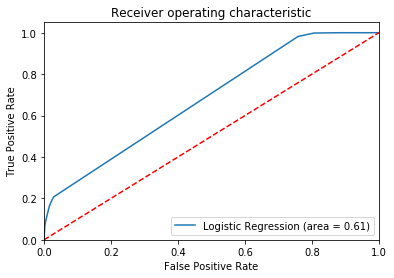

In [102]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt 
logit_roc_auc = roc_auc_score(yceo, logreg.predict(Xceo))
fpr, tpr, thresholds = roc_curve(yceo, logreg.predict_proba(Xceo)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [107]:
Xceo_train, Xceo_test, yceo_train, yceo_test = train_test_split(Xceo, yceo, test_size=0.5, random_state=0)

In [108]:
ceo_log = LogisticRegression()
ceo_log.fit(Xceo_train, yceo_train)

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [109]:
ceo_pred = ceo_log.predict(Xceo_test)

In [110]:
sum(ceo_pred)

945

In [111]:
ceo_pred_full = ceo_log.predict(Xceo)
sum(ceo_pred_full)

1887

In [112]:
print('Accuracy of logistic regression classifier on entire data: {:.2f}'.format(ceo_log.score(Xceo, yceo)))

Accuracy of logistic regression classifier on entire data: 0.97


In [113]:
print(classification_report(yceo, ceo_pred_full))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    434902
           1       0.53      0.06      0.12     15503

   micro avg       0.97      0.97      0.97    450405
   macro avg       0.75      0.53      0.55    450405
weighted avg       0.95      0.97      0.95    450405



In [114]:
from sklearn.metrics import confusion_matrix
cmf = confusion_matrix(yceo_list.tolist(), ceo_pred_full.tolist())
print(cmf)

[[434022    880]
 [ 14496   1007]]


In [115]:
ceo_df['pred'] = ceo_pred_full
ceo_final = ceo_df[ceo_df['pred']==1]
ceo_final = ceo_final.reset_index(drop=True)
CEOs = list(ceo_final['Candidate'])
set(CEOs)

{'Aaron Levie',
 'Aaron Regent',
 'Abigail Johnson',
 'According Australian',
 'According Curalate',
 'According Nanex',
 'Ackman Valeant',
 'Advisor Solutions',
 'Advisory Group',
 'Aer Lingus',
 'Afghan United',
 'Airbus Group',
 'Alan Breed',
 'Alan Joyce',
 'Alan Mulally',
 'Alan Mulallyis',
 'Alan Mullaly',
 'Aleksey Miller',
 'Alex Algard',
 'Allen Questrom',
 'Altegris President',
 'America Founding',
 'American Apparel',
 'American Eagle',
 'American European',
 'American Express',
 'Analyst Earnings',
 'Anand Nallathambi',
 'Anders Gustafsson',
 'Andersen Tax',
 'Anderson Real',
 'Andrei Bugrov',
 'Andrei Cherny',
 'Andrei Kostin',
 'Andy Grove',
 'Angela Ahrendts',
 'Angelo Mozilo',
 'Anglo Irish',
 'Antonio Horta',
 'Antony Jenkins',
 'Apple Pay',
 'Ari Reichental',
 'Armstrong Fired',
 'Art Levinson',
 'Asia Pacific',
 'Asset Management',
 'Australian Institute',
 'Authority Chairman',
 'Auto Nation',
 'Automated Insights',
 'Avishai Abrahami',
 'Bank America',
 'Bank Ameri

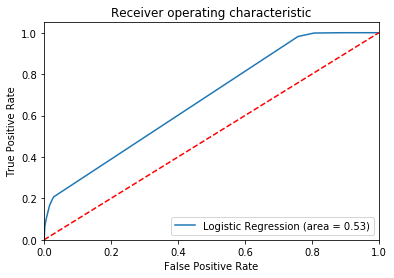

In [116]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(yceo, ceo_log.predict(Xceo))
fpr, tpr, thresholds = roc_curve(yceo, ceo_log.predict_proba(Xceo)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

In [104]:
finalCEO = set(CEOs)
finalCEO = pd.DataFrame(finalCEO)
finalCEO.to_csv("ExtractedCEOs.csv",header=False,index=False)

## Companies

length, corp/corporation/group/holding/inc in word/sentence, company, stock in the sentence, stop words, beginning of sentence, number of words, profit, plural, 

In [ ]:
def company_in_sentence(sentence):
    ret = 0
    if re.search(r'company', sentence.lower()) != None:
        ret = 1
    return ret

In [ ]:
def stock_in_sentence(sentence):
    ret = 0
    if re.search(r'stock', sentence.lower()) != None:
        ret = 1
    return ret

In [ ]:
def shares_in_sentence(sentence):
    ret = 0
    if re.search(r'share', sentence.lower()) != None:
        ret = 1
    return ret

In [ ]:
def trade_in_sentence(sentence):
    ret = 0
    if re.search(r'trad', sentence.lower()) != None:
        ret = 1
    return ret

### Company Specific 

In [ ]:
def length_of_company(item):
    return len(item)

In [ ]:
def plural_word(item):
    plural = 0
    if item[len(item) - 1] == 's':
        plural = 1
    return plural

In [ ]:
def number_of_words(words):
    return len(words)

In [ ]:
def location_at_start(sentence, item):
    start = 0
    if re.search(re.compile(item), sentence).start() == 0:
        start = 1;
    else:
        start = 0;
    return start;

In [ ]:
def company_words(word_phrase):
    corp = 0
    corporation = 0
    group = 0
    holding = 0
    inc = 0
    company = 0
    association = 0
    foundation = 0

    for word in word_phrase:
        if word == "Corp" or word == 'Corp.' or word == 'Corporation':
            corp = 1;
        if word == "Group":
            group = 1;
        if word == "Holding":
            holding = 1;
        if word == "Inc" or word == "Inc.":
            inc = 1;
        if word == "Company":
            company = 1;
        if word == "Association":
            association = 1;
        if word == "Foundation":
            foundation = 1;

    return corp, group, holding, inc, company, association, foundation

In [ ]:
def feature_creator_companies(sentences):
    candidates = []
    for i in range(len(sentences)):
        x = re.findall(r'(([A-Z][A-Za-z0-9]+[ -]?)+)', sentences[i])
        extract = [i[0] for i in x]
        if extract != []:
            comp_in_sent = company_in_sentence(sentences[i])
            #stock = stock_in_sentence(sentences[i])
            shares = shares_in_sentence(sentences[i])
            #trade = trade_in_sentence(sentences[i]) 
            for j in extract:
                
                new_j = j
                if new_j[-1] == ' ':
                    new_len = len(new_j)-1
                    new_j = new_j[0:new_len]
                
                words = re.split(r'[ ]', new_j)
                #length = length_of_company(item)
                plural = plural_word(new_j)
                number_words = number_of_words(words)
                location = location_at_start(sentences[i], new_j)
                comp = company_words(words)
                corp = comp[0]
                group = comp[1]
                holding = comp[2]
                inc = comp[3]
                company = comp[4]
                association = comp[5]
                foundation = comp[6]
                candidates.append([new_j, comp_in_sent, shares, plural, number_words,location, corp, group, holding, inc, company,association, foundation,sentences[i],i])
                #candidates.append([item,company,shares,length,plural,number_words,location,corp,group,holding,inc,company,association,foundation])
    return candidates

In [ ]:
comp_df = pd.DataFrame(feature_creator_companies(sentences), columns = ['Candidate','comp_in_sent','shares', 'plural', 'number_words','location' , 'corp', 'group', 'holding', 'inc', 'company', 'association','foundation','sentence','index'])


In [ ]:
#comp_df = pd.DataFrame(feature_creator_companies(sentences), columns = ['Candidate', 'company', 'stock', 'shares', 'trade', 'length', 'plural', 'number_words','location', 'corp', 'corporation', 'group', 'holding', 'inc', 'company', 'association','foundation'])

In [ ]:
#ex1 = []
#for i in range(len(comp_df)):
#    if comp_df.iloc[i,0][-1] == ' ':
#        st = len(comp_df.iloc[0,0])-1
#        ex1.append(comp_df.iloc[0,0][0:st])
        
#    else:
#        ex1.append(comp_df.iloc[i,0])

In [ ]:
comp_df

### Logistic Regression for Companies

In [ ]:
comp_labels = []
values = set(company['company'].values)
candidates = comp_df['Candidate'].tolist()

for i in range(len(comp_df)):
    if candidates[i] in values:
        comp_labels.append(1)
    else: 
        comp_labels.append(0)
#comp_df['label'] = comp_labels

In [ ]:
Xcomp, ycomp = comp_df.drop(['Candidate','sentence','index'], axis=1), range(len(comp_df))

In [ ]:
Xcomp.sum(axis=0)

In [ ]:
Xcomp = StandardScaler().fit_transform(Xcomp)
Xcomp

In [ ]:
Xcomp_train, Xcomp_test, ycomp_train, ycomp_test = train_test_split(Xcomp, ycomp, test_size=0.5, random_state=42)

In [ ]:
Xcomp_train.shape

In [ ]:
ycomp_train

In [ ]:
comp_train_label = np.zeros(len(ycomp_train))
j=0
for i in ycomp_train:
    comp_train_label[j] = comp_labels[i]
    j = j+1

In [ ]:
sum(comp_train_label)

In [ ]:
Xcomp_test

In [ ]:
ycomp_test

In [ ]:
comp_features = Xcomp_train
comp_label = comp_train_label

comp_log = LogisticRegression()
comp_log.fit(comp_features, comp_label)

In [ ]:
#comp_features = Xcomp_train.iloc[:,Xcomp_train.columns != 'label']
#comp_label = Xcomp_train['label']

#comp_log = LogisticRegression()
#comp_log.fit(comp_features, comp_label)

In [ ]:
comp_pred_feat = Xcomp_test
comp_pred = comp_log.predict(comp_pred_feat)

In [ ]:
#comp_pred_feat = Xcomp_test.iloc[:,Xcomp_test.columns != 'label']
#comp_pred = comp_log.predict(comp_pred_feat)

In [ ]:
sum(comp_pred)

In [ ]:
comp_pred_feat = Xcomp
comp_pred = comp_log.predict(comp_pred_feat)

In [ ]:
comp_df.columns

In [ ]:
comp_log.coef_

In [ ]:
#comp_pred_feat = Xcomp.iloc[:,Xcomp.columns != 'label']
#comp_pred = comp_log.predict(comp_pred_feat)

In [ ]:
sum(comp_pred)

In [ ]:
#print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(comp_log.score(comp_pred_feat, Xcomp_test['label'])))

In [ ]:
comp_df['pred'] = comp_pred
comp_final = comp_df[comp_df['pred']==1]
comp_final = comp_final.reset_index(drop=True)
comps = list(comp_final['Candidate'])
set(comps)

In [ ]:
finalCompany = set(comps)
finalCompany = pd.DataFrame(finalCompany)
finalCompany.to_csv("ExtractedCompanies.csv",header=False,index=False)

In [ ]:
#comp_final = pd.DataFrame(np.concatenate((Xcomp,np.array(comp_pred)[:,None]),axis=1))
#comp_final = comp_final[comp_final.iloc[:,13]==1]
#comp_final = comp_final.reset_index()

#Companies = []
#for i in comp_final['index']:
#    Companies.append(comp_df.loc[i,'Candidate'])
#Companies = list(comp_final['Candidate'])
#Companies

## predict_proba outputs the probabilities of each class for logistic regression

# take a set of the features so that you do not have repeats

## Percentages

In [ ]:
def percent_after(sent,num):
    try:
        perc = 0
        nxt = ''        
        split = re.split(r'[ ]', sent)
        if num in split:
            num_index = split.index(num)
            nxt = split[num_index+1].lower()
            if nxt == 'percentage' or nxt == "percent":
                perc = 1;
                return perc;
        char_index = re.search(num, sent.lower()).start() + len(num)
        if sent[char_index] == '%' or sent[char_index+1] == '%':
            perc = 1;
            return perc;
        else: perc = 0;
            
    except IndexError:
        perc = 0;
    return perc;

In [ ]:
def greater_than_1800(num):
    try:
        year = 0
        num = int(num)
        
        if num > 1800: year = 1;
        else: year = 0;
    except ValueError: pass
    return year;

In [ ]:
def feature_creator_percent(ls):
    numbers = []
    for i in range(len(ls)):
        re1 = re.findall(r'\d*\.?\d+', ls[i])
        re2 = re.findall(r'one[\s|-]?hundred|fourteen|fifteen|sixteen|seventeen|eighteen|nineteen|zero|one|two|three|four|five|six|seven|eight|nine|ten|eleven|twelve|thirteen', ls[i].lower())
        re3 = re.findall(r'((twenty|thirty|fourty|fifty|sixty|seventy|eighty|ninety)(\s|-)?(one|two|three|four|five|six|seven|eight|nine)?)', ls[i].lower())
        re3 = [i[0] for i in re3]
        extract = re1 + re2 + re3
        if extract != []:
            for item in extract:
                year = greater_than_1800(item)
                perc = percent_after(ls[i],item)
                numbers.append([item, year, perc,i])
    return numbers

In [ ]:
numbers = pd.DataFrame(feature_creator_percent(sentences), columns = ['numbers','year','perc','sentence'])

In [ ]:
numbers.head()

## Logistic Regression for Percentages

In [ ]:
#values = percent['perc'].values

In [ ]:
#def remove_perc(ls):
#    nums = []
#    for i in range(len(ls)):
#        if ls[i][-1] == '%':
#            ls[i] = ls[i].replace("%", "")
#            nums.append(ls[i])
        
#        elif ls[i][(len(ls[i])-len('percent')):len(ls[i])] == 'percent':
#            ls[i] = ls[i].replace(" percent", "")
#            nums.append(ls[i])
        
#        elif values[i][(len(ls[i])-len('percentage')):len(ls[i])] == 'percentage':
#            ls[i] = ls[i].replace(" percentage", "")
#            nums.append(ls[i])
        
#        else:
#            nums.append(ls[i])
            
#    return nums;

In [ ]:
#percents = set(remove_perc(values))

### Manually creating a test set of 200 data points

I had to do this becuase there was no logical way to compare to the percentage csv file because my numbers are 

In [ ]:
#labels=[]
#candidates = numbers['numbers'].tolist()

#for i in range(len(candidates)):
#    if candidates[i] in percents:
#        labels.append(1)
#    else: 
#        labels.append(0) 
#numbers['label'] = labels

In [ ]:
train_perc = pd.read_csv("/Users/charlesmarshall/Desktop/IEMS 308/Project 3/all/train_label.csv", engine = "python", names = ['train'])

In [ ]:
train_perc.head()

In [ ]:
Xperc_train = numbers[0:100]
Xperc_train['label'] = train_perc
Xperc_train = Xperc_train.drop(['numbers','sentence'], axis=1)

In [ ]:
yperc_train = list(range(len(Xperc_train)))

In [ ]:
#Xperc, yperc = numbers.drop(['numbers','sentence'], axis=1), range(len(numbers))

In [ ]:
#Xperc

In [ ]:
#Xperc_train, Xperc_test, yperc_train, yperc_test = train_test_split(Xperc, yperc, test_size=0.5, random_state=42)

In [ ]:
Xperc_test = numbers.drop(numbers.index[0:101],axis=0)
Xperc_test = Xperc_test.drop(['numbers','sentence'],axis=1)

In [ ]:
yperc_train = Xperc_train.index.tolist()

In [ ]:
Xperc_train

In [ ]:
yperc_train

In [ ]:
Xperc_test

In [ ]:
yperc_test = Xperc_test.index.tolist()

In [ ]:
perc_features = Xperc_train.iloc[:,Xperc_train.columns != 'label']
perc_label = Xperc_train['label']

perc_log = LogisticRegression()
perc_log.fit(perc_features, perc_label)

In [ ]:
perc_pred_feat = Xperc_test
perc_pred = perc_log.predict(perc_pred_feat)

In [ ]:
sum(perc_pred)

In [ ]:
Xperc = numbers.drop(['numbers','sentence'],axis=1)
perc_pred_full = perc_log.predict(Xperc)
sum(perc_pred_full)

In [ ]:
numbers['pred'] = perc_pred_full
perc_df = numbers[numbers['pred']==1]
perc_df = perc_df.reset_index(drop=True)
sentences[perc_df.iloc[0,3]]
perc_df.iloc[0,0]

In [ ]:
def extract_percentages(sent,num):
    percentage = num
    nxt = ''
    split = re.split(r'[ ]', sent)
    char_index = re.search(num, sent.lower()).start() + len(num)
    if sent[char_index] == '%':
        percentage = num + '%'
        return percentage;
    if sent[char_index+1] == '%':
        percentage = num + ' %'
        return percentage; 
    
    if num in split:
        num_index = split.index(num)
        nxt = split[num_index+1].lower()
        if nxt == 'percentage':
            percentage = num + ' ' + nxt
            return percentage;
        if nxt == 'percent':
            percentage = num + ' ' + nxt
            return percentage;
        else:
            return percentage;
    else:
        return percentage;

In [ ]:
percentages = []
for i in range(len(perc_df)):
    sent = sentences[perc_df.iloc[i,3]]
    num = perc_df.iloc[i,0]
    percentages.append(extract_percentages(sent,num))

In [ ]:
percentages

In [ ]:
finalPercentage = set(percentages)
finalPercentage = pd.DataFrame(finalPercentage)
finalPercentage.to_csv("ExtractedPercantages.csv",header=False,index=False)